# Write csv with CESM data 

- Time-series of mean annual temperature, averaged over the MS basin (roughly), for the entire run
- Time-series of mean annual evaporation, averaged over the MS basin (roughly), for the entire run
- Lat/Lon/Value for period 1000-1200 and Lat/Long/Value for period 1600-1800 for 
 - (1) winter snow depth, 
 - (2) seasonal and annual precip (winter, spring, summer, fall)
 - (3) soil water, and 
 - (4) discharge
 

In [1]:
writeto = r'C:\Users\bydd1\OneDrive\Documents\Research\CESM Formatted_new'
directory = r'D:\RIVERS_new'

In [2]:
import pandas as pd 
import time as pytime
import numpy as np 
import os 
import datetime as dt
import geopandas as gpd 
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs
import sys
sys.path.insert(1, r'C:\Users\bydd1\OneDrive\Documents\Research\Code for Babes\miss-atmo')

import env_methods as em 

## Import data

In [3]:
start_time = pytime.time()

os.chdir(directory)

P=np.load('PRECT_LME_USA_ENSMEAN_850-1850.npy') # precip m/s
T=np.load('TREFHT_LME_USA_ENSMEAN_850-1850.npy') # temp K
EVAP=np.load('QSOIL_USA_LME_ENSMEAN_850-1850.npy') # evaporation mm/s
SNOWHLND=np.load('SNOWHLND_LME_USA_ENSMEAN_850-1850.npy') # ? 
SOILLIQ=np.load('SOILLIQ_USA_LME_ENSMEAN_850-1850.npy') # soil liquid water kg/m2
QCHANR=np.load('QCHANR_USA_LME_ENSMEAN_850-1850.npy') # river flow m3/s
SOILICE=np.load('SOILICE_USA_LME_ENSMEAN_850-1850.npy') # soil ice kg/m2
QRUNOFF = np.load('QRUNOFF_LME_USA_ENSMEAN_850-1850.npy') #total liquid runoff mm/s
QSNOMELT = np.load('QSNOMELT_LME_USA_ENSMEAN_850-1850.npy') #snow melt, mm/s

var = {'P':P, 
      'T':T,
      'EVAP':EVAP,
      'SNOWHLND':SNOWHLND,
      'SOILLIQ':SOILLIQ,
      'QCHANR':QCHANR,
      'SOILICE':SOILICE,
      'QSNOMELT':QSNOMELT,
      'QRUNOFF':QRUNOFF}
print('Loading variables = ' + str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')

var_def = {'P':'Precipitation', 
      'T':'Temperature',
      'EVAP':'Evaporation',
      'SNOWHLND':'Water equivalent snow depth',
      'SOILLIQ':'Soil Liquid Water',
      'QCHANR':'River Flow',
      'SOILICE':'Soil Ice',
      'QRUNOFF':'Total liquid runoff',
      'QSNOMELT':'Snow melt'
          }
start_time = pytime.time()
lats=np.load('NA_ATM_LME_lats.npy')
lons=np.load('NA_ATM_LME_lons.npy')

q_lats=np.load('CESM_LME_USA_lats.npy')
q_lons=np.load('CESM_LME_USA_lons.npy')
print('Loading parameters = ' + str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')

time = []
for i in range(850,1850):
    for j in range(1,13):
        time.append(dt.datetime(i, j, 1))
    

Loading variables = 10.28068 seconds elapsed
Loading parameters = 0.01695 seconds elapsed


In [4]:
# remove nans 
for v in var: 
    var[v][var[v] > 10 **30] = np.nan
var['SOILLIQ'][var['SOILLIQ'] == 0] = np.nan


## Compress to mean annual 

In [5]:
start_time = pytime.time()
var_ann = {}
var_mean = {}
for v in var:
    for i in np.arange(0,12000, 12):
        subset = var[v][i:i+12,:,:]
        subset = np.mean(subset, axis = 0)
        subset = np.expand_dims(subset, 0)
        if i == 0:
            var_new = subset
        else:
            var_new = np.concatenate((var_new, subset), axis = 0)
    var_ann[v] = var_new
    var_mean[v] = np.mean(var_new, axis = 0)
print('Compressing to annual = ' +str(np.round(pytime.time() - start_time, 5)) + ' seconds elapsed')

Compressing to annual = 44.41001 seconds elapsed


In [6]:
var_mean['P'].shape

(16, 20)

## Write time-series files

In [7]:
new_lons = lons - 360
cLons = [-100, -80]
cLats = [30, 45]
cLons_ind = [em.find_closest_val(x, new_lons) for x in cLons]
cLats_ind =[em.find_closest_val(x, lats) for x in cLats]

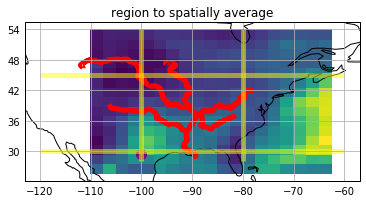

In [8]:
path = r'D:\Shapefiles\msrivs\msrivs.shp'

shp = gpd.read_file(path)
plt.figure()
ax = plt.subplot(projection = ccrs.PlateCarree())
ax.coastlines()
shp.plot(ax=ax, edgecolor='red', linewidth = 5)
plt.pcolormesh(lons, lats, var['P'][0, :, :])
plt.hlines(y = (30, 45), xmin = -120,xmax = -60, color = 'yellow', linewidth = 5, alpha = 0.5)
plt.vlines(x = (-100, -80), ymin = 28, ymax = 54, color = 'yellow', linewidth = 5, alpha = 0.5)
gl = ax.gridlines(draw_labels = True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('region to spatially average')
plt.scatter(new_lons[cLons_ind[0]], lats[cLats_ind[0]], s = 100, color = 'purple')

In [9]:
pd_timeseries = pd.DataFrame()
pd_timeseries['time'] = np.arange(850, 1850)

for v in ['T', 'EVAP']:
    data = var_ann[v][:, cLats_ind[0]:cLats_ind[1], cLons_ind[0]:cLons_ind[1]]
    average = np.nanmean(data, axis = (1, 2))
    if v == 'T':
        pd_timeseries['temp'] = average
    else: 
        pd_timeseries['evap'] = average
pd_timeseries

,time,temp,evap
0,850,287.515430,0.000005
1,851,287.845156,0.000005
2,852,287.469500,0.000005
3,853,287.815297,0.000005
4,854,287.719776,0.000005
...,...,...,...
995,1845,287.737446,0.000005
996,1846,287.343864,0.000005
997,1847,287.545789,0.000005
998,1848,287.376264,0.000005


Text(0.5, 0, 'time')

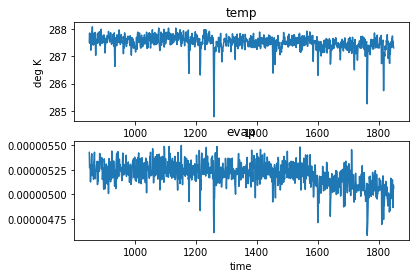

In [10]:
plt.figure()
plt.subplot(2,1,1)
plt.title('temp')
plt.ylabel('deg K')
plt.plot(pd_timeseries['time'], pd_timeseries['temp'] )
plt.subplot(2,1,2)
plt.plot(pd_timeseries['time'], pd_timeseries['evap'] )
plt.title('evap')
plt.xlabel('time')

In [11]:
pd_timeseries = pd_timeseries.fillna(-9999)
pd_timeseries.to_csv(os.path.join(writeto, 'timeseries.csv'))

## Get spatial Data
- Lat/Lon/Value for period 1000-1200 and Lat/Long/Value for period 1600-1800 for 
 - (1) winter snow depth, 
 - (2) seasonal and annual precip (winter, spring, summer, fall)
 - (3) soil water, and 
 - (4) discharge

In [12]:
seasons_def = {'winter':[12, 1, 2],
              'spring':[3,4,5],
              'summer':[6,7,8],
              'fall':[9,10,11]}

b_indices = {}

b_indices[0] = []
b_indices[1] = []
for i in range(len(time)):
    t = time[i]
    if t.year in range(1000, 1200):
        b_indices[0].append(i)
    if t.year in range(1600, 1800):
        b_indices[1].append(i)

seas_ind = {}

for s in seasons_def:
    seas_ind[s] = {}
    seas_ind[s][0] = []
    seas_ind[s][1] = []
    for i in range(len(time)):
        t = time[i]
        if t.month in seasons_def[s]:
            if t.year in range(1000, 1200):
                seas_ind[s][0].append(i)
            if t.year in range(1600, 1800):
                seas_ind[s][1].append(i)
        
        

In [20]:
df = pd.DataFrame()
lat = []
lon = []

var_spec = ['SNOWHLND', 'SOILLIQ', 'P','EVAP', 'QRUNOFF', 'QSNOMELT']

for i in range(len(lats)):
    for j in range(len(lons)):
        lat.append(lats[i])
        lon.append(new_lons[j])

df['lat'] = lat
df['lon'] = lon

for v in range(len(var_spec)):
    for b in [0, 1]:
        if v != 0: 
            data = var[var_spec[v]][b_indices[b], :, :]
        else:
            data = var[var_spec[v]][seas_ind['winter'][b], :, :]
        lis = []
        for i in range(len(lats)):
            for j in range(len(lons)):
                val = np.mean(data[:, i, j])
                lis.append(val)
        df[var_spec[v] + str(b)] = lis

        
for s in seasons_def:
    for b in [0, 1]:
        lis = []
        data = var['P'][seas_ind[s][b], :, :]
        for i in range(len(lats)):
            for j in range(len(lons)):
                val = np.mean(data[:, i, j])
                lis.append(val)
        df['P' + str(b) + s] = lis

In [21]:
df = df.fillna(-9999)
df.to_csv(os.path.join(writeto, 'spatial_data.csv'))
df

,lat,lon,SNOWHLND0,SNOWHLND1,SOILLIQ0,SOILLIQ1,P0,P1,EVAP0,EVAP1,...,QSNOMELT0,QSNOMELT1,P0winter,P1winter,P0spring,P1spring,P0summer,P1summer,P0fall,P1fall
0,25.578947,-110.0,0.000000e+00,0.000000e+00,1108.544300,1107.691624,3.176009e-08,3.178706e-08,0.000012,0.000012,...,2.774627e-12,2.814396e-12,2.754670e-08,2.727511e-08,6.818435e-09,6.759838e-09,2.220696e-08,2.267798e-08,7.046828e-08,7.043531e-08
1,25.578947,-107.5,6.616436e-10,1.544587e-08,1303.575472,1298.685665,5.667637e-08,5.614445e-08,0.000003,0.000002,...,4.785920e-10,5.955877e-10,3.874258e-08,3.887213e-08,1.611280e-08,1.582861e-08,9.265112e-08,9.137203e-08,7.919898e-08,7.850502e-08
2,25.578947,-105.0,7.983689e-06,1.241654e-05,1020.569706,975.686087,3.473992e-08,3.520041e-08,0.000014,0.000012,...,7.174871e-08,7.986202e-08,2.547149e-08,2.550274e-08,2.183581e-08,2.196336e-08,4.740421e-08,4.848819e-08,4.424817e-08,4.484734e-08
3,25.578947,-102.5,6.211782e-05,5.433449e-05,1070.667983,1056.252599,2.953527e-08,2.986647e-08,0.000022,0.000021,...,2.949225e-07,3.137107e-07,2.308015e-08,2.288248e-08,3.279885e-08,3.312721e-08,2.548429e-08,2.609452e-08,3.677777e-08,3.736166e-08
4,25.578947,-100.0,2.493112e-05,2.577173e-05,1210.389977,1122.749379,3.234351e-08,3.208858e-08,0.000016,0.000010,...,1.970316e-07,2.238317e-07,2.735885e-08,2.729878e-08,4.537885e-08,4.382987e-08,1.616542e-08,1.633824e-08,4.047093e-08,4.088745e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,54.000000,-72.5,1.102016e-01,1.105687e-01,954.827502,945.356910,2.440844e-08,2.408823e-08,0.000005,0.000005,...,1.106172e-05,1.101486e-05,1.297701e-08,1.252905e-08,1.712120e-08,1.695964e-08,3.564344e-08,3.557801e-08,3.189210e-08,3.128622e-08
316,54.000000,-70.0,1.036611e-01,1.051555e-01,1194.773535,1186.571804,2.434939e-08,2.405908e-08,0.000004,0.000004,...,1.074667e-05,1.073686e-05,1.278787e-08,1.238474e-08,1.823633e-08,1.810576e-08,3.729609e-08,3.714546e-08,2.907727e-08,2.860035e-08
317,54.000000,-67.5,1.134707e-01,1.144680e-01,1254.084324,1247.755612,2.540716e-08,2.505344e-08,0.000007,0.000007,...,1.190558e-05,1.187766e-05,1.374923e-08,1.334037e-08,1.967849e-08,1.952075e-08,3.999357e-08,3.962166e-08,2.820736e-08,2.773097e-08
318,54.000000,-65.0,1.181399e-01,1.187301e-01,926.689685,922.763561,2.713449e-08,2.677213e-08,0.000006,0.000006,...,1.251942e-05,1.249390e-05,1.542883e-08,1.502502e-08,2.211810e-08,2.191443e-08,4.239622e-08,4.206061e-08,2.859479e-08,2.808846e-08


## Discharge File
seperate because its at a different resolution

In [15]:
dis_df = pd.DataFrame()

for b in [0, 1]:
    data = var['QCHANR'][b_indices[b], :, :]
    lat = []
    lon = []
    val = []
    for i in range(len(q_lats)):
        for j in range(len(q_lons)):
            lat.append(q_lats[i])
            lon.append(q_lons[j])
            val.append(np.mean(data[:, i, j]))
    dis_df['QCHANR' + str(b)] = val
            
dis_df['lat'] = lat
dis_df['lon'] = lon

In [16]:
dis_df = dis_df.fillna(-9999)
dis_df.to_csv(os.path.join(writeto, 'spatial_data_discharge.csv'))

In [17]:
var['T'].shape


(12000, 16, 20)

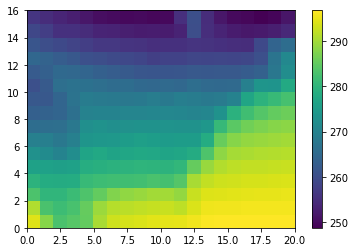

In [18]:
plt.figure()
mesh = plt.pcolormesh(var['T'][-1, :, :])
plt.colorbar(mesh)

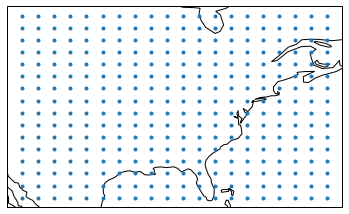

In [19]:
plt.figure()
ax = plt.subplot(projection = ccrs.PlateCarree())
plt.plot(df['lon'], df['lat'], '.')
ax.coastlines()